In [1]:
# DataFrame
import pandas as pd

# nltk
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Utility
import re

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# matplotlib
import matplotlib.pyplot as plt

# seaborn
import seaborn as sns

# pickle
import pickle

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guillaume\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
%%time
df = pd.read_csv("../data/tweets.csv", low_memory=False)

CPU times: total: 15.6 ms
Wall time: 26 ms


In [4]:
df.head()

,tweet,label
0,Police arrest 10 suspects in connection with a...,WAR
1,Unrest continues in the Middle East as fightin...,WAR
2,Authorities seize a shipment of illegal drugs ...,WAR
3,Breaking: A shootout between rival gangs in th...,WAR
4,Police investigate a series of carjackings in ...,WAR


## Pre-Process

In [5]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [6]:
def preprocess(text, stem=False):
    # Remove link, user and special characters
    text = re.sub(
        r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", " ", str(text).lower()
    ).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [7]:
%%time
df.tweet = df.tweet.apply(lambda x: preprocess(x))

CPU times: total: 15.6 ms
Wall time: 176 ms


In [8]:
df.head()

,tweet,label
0,police arrest 10 suspects connection recent st...,WAR
1,unrest continues middle east fighting intensif...,WAR
2,authorities seize shipment illegal drugs worth...,WAR
3,breaking shootout rival gangs city leaves thre...,WAR
4,police investigate series carjackings suburbs ...,WAR


## Little analysis

#### Label distribution

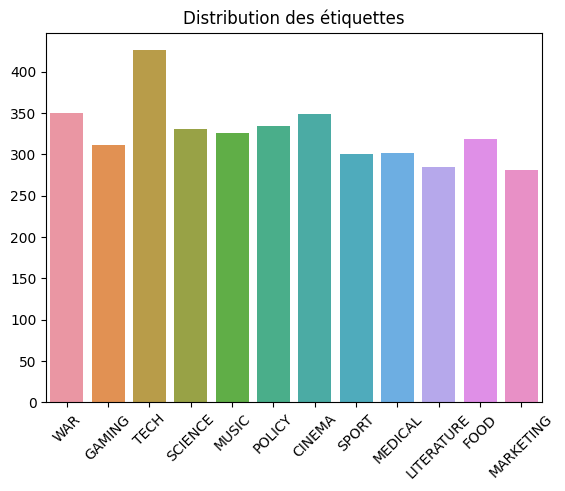

In [9]:
# convert a collection of text documents to a matrix of token counts.
vectorizer = CountVectorizer()
X_vec = vectorizer.fit_transform(df["tweet"])

# get the list of vocabulary words
vocab = vectorizer.get_feature_names_out()

labels = df["label"].values
label_counts = dict(FreqDist(labels))

sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title("Distribution des étiquettes")
plt.xticks(rotation=45)
plt.show()

#### 20 most frequent words

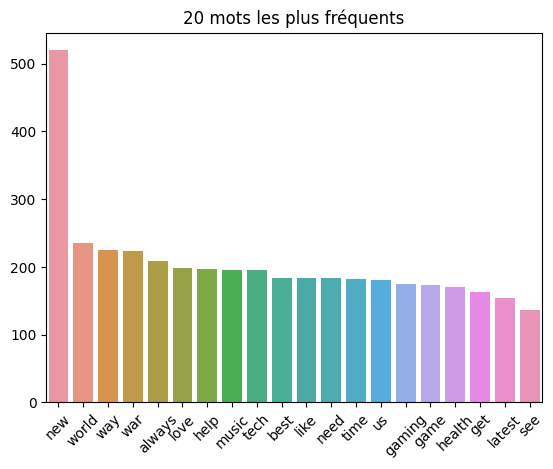

In [10]:
word_counts = dict(zip(vocab, X_vec.sum(axis=0).tolist()[0]))

top_words = sorted(word_counts, key=word_counts.get, reverse=True)[:20]
sns.barplot(x=top_words, y=[word_counts[word] for word in top_words])
plt.title("20 mots les plus fréquents")
plt.xticks(rotation=45)
plt.show()

## Split data into training and test sets

In [11]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
    df["tweet"], df["label"], test_size=0.2, random_state=42
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

CPU times: total: 31.2 ms
Wall time: 55.9 ms


## Train model

In [12]:
%%time
model = LogisticRegression()
model.fit(X_train_vec, y_train)

CPU times: total: 188 ms
Wall time: 721 ms


LogisticRegression()

### Accuracy

In [13]:
y_pred = model.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9272030651340997


### Export model

In [14]:
with open("../data/tweet_analyzer_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("../data/tweet_analyzer_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

## Test

In [15]:
def prompt_preprocess(prompt):
    prompt_processed = preprocess(prompt)
    prompt_vec = vectorizer.transform([prompt_processed])

    print(f"\nprompt_processed:\n{prompt_processed}\n")
    return prompt_vec


def diplay_probability(prompt_vec):
    proba = model.predict_proba(prompt_vec)[0]

    classes = model.classes_
    sorted_indices = proba.argsort()[::-1]
    for i in sorted_indices:
        print(f"{classes[i]}: {proba[i]*100:.2f}%")

### Paste a tweet

In [16]:
prompt = input("Paste a tweet: ")

Paste a tweet:  Can't wait for you all to see our amazing cast in action!


### Result

In [17]:
%%time
prompt_processed = prompt_preprocess(prompt)
diplay_probability(prompt_processed)


prompt_processed:
wait see amazing cast action

CINEMA: 60.69%
TECH: 11.03%
GAMING: 8.84%
SPORT: 3.36%
POLICY: 3.05%
MUSIC: 2.88%
WAR: 2.44%
FOOD: 2.23%
MARKETING: 1.84%
LITERATURE: 1.57%
MEDICAL: 1.14%
SCIENCE: 0.93%
CPU times: total: 0 ns
Wall time: 1.75 ms
